# Survival Analysis of PBTA miRNA data
### Author: Shehbeel Arif
### Affiliation: Center for Data-driven Discovery in Biomedicine (D3b), The Children's Hospital of Philadelphia
### Contact: arifs2@chop.edu
### Goal: To find prognostic miRNA that correlate with overall survival (OS) and progression-free survival (PFS)

In [111]:
# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Modeling libraries
import joblib
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline

# Survival Libraries
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

In [98]:
# Load Open PBTA miRNA dataset
mirna = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_mirna_tdata.csv")

# Drop Schwannomas, Teratomas, and GNTs
mirna = mirna[mirna['class'] != 'Schwannoma']
mirna = mirna[ mirna['class'] != 'Teratoma']
mirna = mirna[ mirna['class'] != 'GNT']

# Reset index
mirna = mirna.reset_index(drop=True)

# Remove '104-' and '_1' from Sample_ID
for i in range(len(mirna['Sample_ID'])):
    mirna['Sample_ID'][i] = mirna['Sample_ID'][i][4:][:-2]

# See if there are any duplicates
#mirna['Sample_ID'].duplicated().value_counts()

# Drop duplicates
mirna = mirna.drop_duplicates(subset='Sample_ID')

# Reset index
mirna = mirna.reset_index(drop=True)

mirna

/var/folders/2_/bpqlxz152435vr38cn25bznr99ftyg/T/ipykernel_5731/1422971989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mirna['Sample_ID'][i] = mirna['Sample_ID'][i][4:][:-2]


,Sample_ID,class,let-7a-2-3p,let-7a-3p,let-7a-5p,let-7b-5p,let-7c-3p,let-7c-5p,let-7d-3p,let-7d-5p,...,miR-944,miR-95-3p,miR-95-5p,miR-9-5p,miR-96-3p,miR-96-5p,miR-98-3p,miR-99a-5p,miR-99b-3p,miR-99b-5p
0,7316-2187,ATRT,54,142,52379,21782,216,35044,1729,19661,...,2,165,7,25001,14,1853,10,35498,422,10995
1,7316-122,ATRT,136,109,39346,10494,38,16308,2132,20500,...,34,51,35,1840,46,144,20,9680,443,7100
2,7316-2186,ATRT,13,74,39079,16633,159,30219,1614,13793,...,3,27,6,5624,1,54,3,36509,312,7834
3,7316-2933,ATRT,28,64,19514,5273,38,9328,1003,10016,...,2,307,3,4800,6,3818,3,9431,431,9542
4,7316-1771,ATRT,144,92,69964,20807,245,43025,1101,16204,...,1,1907,0,94839,0,293,8,69583,375,11645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,7316-2169,Medulloblastoma,11,43,120835,51749,213,83111,288,9561,...,0,60,2,97559,6,3395,2,85897,130,3151
251,7316-306,Medulloblastoma,10,62,156348,68643,251,112690,784,16713,...,0,416,0,237747,0,600,3,129015,288,7881
252,7316-1772,Medulloblastoma,103,46,159176,77675,45,82063,3781,24020,...,1,1157,0,145363,13,14861,0,62217,528,16372
253,7316-2986,Medulloblastoma,3,51,209309,59958,105,84189,720,13809,...,4,90,0,219567,72,59528,2,60116,323,9093


In [105]:
# Load OpenPTBA Clinical data
clinical = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_clinical_data.csv")
# Drop duplicates
clinical = clinical.drop_duplicates(subset='Sample_ID')
# Drop NAs present in OS_survival column
clinical = clinical.dropna(subset=['OS_days', 'OS_status_boolean'])
# Reset index
clinical = clinical.reset_index(drop=True)

clinical

,Sample_ID,Kids_First_Biospecimen_ID,aliquot_id,Kids_First_Participant_ID,experimental_strategy,sample_type,composition,tumor_descriptor,primary_site,reported_gender,...,integrated_diagnosis,Notes,harmonized_diagnosis,broad_histology,short_histology,cancer_group,OS_status,OS_status_boolean,OS_days,PFS_days
0,7316-100,BS_BHR08WGW,601598,PT_6TZR2DH1,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,3361.0,3361.0
1,7316-124,BS_PRR8K9GE,573169,PT_CEWNZVKF,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,1833.0,1833.0
2,7316-166,BS_GMJBGBWB,573166,PT_8GBF5MTD,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,3373.0,3373.0
3,7316-1748,BS_B53Z0T1Q,573141,PT_7RMS6K08,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,1835.0,1835.0
4,7316-1775,BS_1HFK0SXV,571427,PT_2GPH62JS,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,Adamantinomatous craniopharyngioma,Updated via OpenPBTA subtyping,Adamantinomatous craniopharyngioma,Tumors of sellar region,Craniopharyngioma,Craniopharyngioma,LIVING,False,2323.0,577.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,7316-3045,BS_983Z6CA6,717158,PT_3KM9W8S8,RNA-Seq,Tumor,Solid Tissue,Progressive,Other locations NOS;Spinal Cord- Lumbar/Thecal...,Female,...,NaN,NaN,Atypical Teratoid Rhabdoid Tumor (ATRT),Embryonal tumor,ATRT,Atypical Teratoid Rhabdoid Tumor,DECEASED,True,523.0,335.0
231,7316-376,BS_M4923M40,549569,PT_MTE126WM,RNA-Seq,Tumor,Solid Tissue,Progressive,Cerebellum/Posterior Fossa;Other locations NOS,Female,...,NaN,NaN,Atypical Teratoid Rhabdoid Tumor (ATRT),Embryonal tumor,ATRT,Atypical Teratoid Rhabdoid Tumor,LIVING,False,1729.0,13.0
232,7316-479,BS_90B22NGP,734514,PT_JCECCFPB,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Cerebellum/Posterior Fossa,Male,...,NaN,NaN,Atypical Teratoid Rhabdoid Tumor (ATRT),Embryonal tumor,ATRT,Atypical Teratoid Rhabdoid Tumor,DECEASED,True,29.0,29.0
233,7316-878,BS_J483EMFP,549572,PT_ESHACWF6,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Temporal Lobe,Female,...,NaN,NaN,Atypical Teratoid Rhabdoid Tumor (ATRT),Embryonal tumor,ATRT,Atypical Teratoid Rhabdoid Tumor,DECEASED,True,580.0,19.0


In [106]:
dfm = pd.merge(clinical, mirna, how='inner', on='Sample_ID')
dfm

,Sample_ID,Kids_First_Biospecimen_ID,aliquot_id,Kids_First_Participant_ID,experimental_strategy,sample_type,composition,tumor_descriptor,primary_site,reported_gender,...,miR-944,miR-95-3p,miR-95-5p,miR-9-5p,miR-96-3p,miR-96-5p,miR-98-3p,miR-99a-5p,miR-99b-3p,miR-99b-5p
0,7316-100,BS_BHR08WGW,601598,PT_6TZR2DH1,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,79,687,7,30505,16,10291,12,95557,211,6040
1,7316-124,BS_PRR8K9GE,573169,PT_CEWNZVKF,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,96,102,0,85,22,16682,3,99668,116,2904
2,7316-166,BS_GMJBGBWB,573166,PT_8GBF5MTD,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,12,310,0,120800,1,3443,2,80364,238,6786
3,7316-1748,BS_B53Z0T1Q,573141,PT_7RMS6K08,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Female,...,11,68,0,218,3,1436,0,9012,15,588
4,7316-1775,BS_1HFK0SXV,571427,PT_2GPH62JS,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Suprasellar/Hypothalamic/Pituitary,Male,...,43,218,6,14479,23,16490,2,90292,97,2741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,7316-3045,BS_983Z6CA6,717158,PT_3KM9W8S8,RNA-Seq,Tumor,Solid Tissue,Progressive,Other locations NOS;Spinal Cord- Lumbar/Thecal...,Female,...,3,271,2,19967,21,18663,2,81959,632,16020
231,7316-376,BS_M4923M40,549569,PT_MTE126WM,RNA-Seq,Tumor,Solid Tissue,Progressive,Cerebellum/Posterior Fossa;Other locations NOS,Female,...,2,33,0,521,3,80,10,123645,499,12381
232,7316-479,BS_90B22NGP,734514,PT_JCECCFPB,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Cerebellum/Posterior Fossa,Male,...,2,1325,0,148567,0,246,8,26560,440,13824
233,7316-878,BS_J483EMFP,549572,PT_ESHACWF6,RNA-Seq,Tumor,Solid Tissue,Initial CNS Tumor,Temporal Lobe,Female,...,83,1324,59,139740,94,12824,45,66757,292,4427


In [142]:
#dfm.to_csv("pbta_clinical_mirna_merge.csv")

### Split into Training and Testing Set

In [109]:
X = dfm.iloc[:,39:]
y = dfm.iloc[:,35:37]
#X.head(5)
y

,OS_status_boolean,OS_days
0,False,3361.0
1,False,1833.0
2,False,3373.0
3,False,1835.0
4,False,2323.0
...,...,...
230,True,523.0
231,False,1729.0
232,True,29.0
233,True,580.0


### Normalize Data

In [114]:
# Normalize the miRNA gene expression features (z-score normalization)
# Create scaler object
scaler = StandardScaler()
# Fit and transform the features
Xs = scaler.fit_transform(X)
# Turn the transformed feature matrix to dataframe
Xs = pd.DataFrame(Xs)

# Remove columns with std dev of zero
for col in Xs:
    if (Xs[col].std() == 0):
        Xs = Xs.drop(columns=[col])

Xs.columns = X.columns

Xs

,let-7a-2-3p,let-7a-3p,let-7a-5p,let-7b-5p,let-7c-3p,let-7c-5p,let-7d-3p,let-7d-5p,let-7e-3p,let-7e-5p,...,miR-944,miR-95-3p,miR-95-5p,miR-9-5p,miR-96-3p,miR-96-5p,miR-98-3p,miR-99a-5p,miR-99b-3p,miR-99b-5p
0,-0.665450,3.009988,-0.231685,0.075989,0.227659,0.399551,-0.107366,0.607582,-0.188632,0.040679,...,3.993639,0.242034,0.793791,-0.800933,0.216750,0.216919,1.366822,0.701024,-0.181533,-0.328154
1,-0.980564,0.738972,0.600014,0.577777,0.355401,0.996299,0.189322,0.466566,-0.407691,-0.582181,...,4.930106,-0.668948,-0.374175,-1.127282,0.375594,0.456729,-0.314870,0.783788,-0.358857,-0.880780
2,-0.392351,0.165912,0.202093,0.189064,-0.059760,0.453265,-0.256155,0.103876,-0.211100,0.056023,...,0.302857,-0.345043,-0.374175,0.167762,-0.180362,-0.040040,-0.501725,0.395154,-0.131136,-0.196693
3,-1.064595,-1.001433,-1.215095,-0.994589,-0.810244,-1.261142,-1.104345,-1.231023,-1.014316,-1.564247,...,0.247771,-0.721894,-0.374175,-1.125855,-0.127414,-0.115349,-0.875434,-1.041323,-0.547380,-1.288906
4,-0.875526,0.526728,-0.349341,-0.212918,0.427256,0.083366,-0.479785,-0.345389,-0.609899,-0.897098,...,2.010533,-0.488309,0.626939,-0.972862,0.402068,0.449525,-0.501725,0.595028,-0.394322,-0.909504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1.456320,-0.194904,0.472997,0.012085,-0.155567,0.359642,0.490465,1.179471,1.664943,2.034107,...,-0.192919,-0.405775,-0.040471,-0.913986,0.349120,0.531063,-0.501725,0.427265,0.604290,1.430524
231,-0.518396,1.078563,-0.327297,-0.373433,1.345401,0.111001,0.000440,0.349862,0.811175,0.746016,...,-0.248006,-0.776397,-0.374175,-1.122605,-0.127414,-0.166231,0.993113,1.266499,0.356037,0.789259
232,-0.833511,0.059790,1.427213,0.964100,-0.570728,0.540075,1.553375,1.409600,1.603157,1.561906,...,-0.248006,1.235549,-0.374175,0.465650,-0.206836,-0.160002,0.619403,-0.688042,0.245910,1.043545
233,1.813449,2.054888,-0.854899,-0.615802,0.922256,-0.507054,-0.516314,-0.556385,0.097830,-0.634492,...,4.213984,1.233991,9.470117,0.370953,2.281729,0.311965,7.533025,0.121215,-0.030342,-0.612397


In [115]:
# Convert y (OS_surival and boolean censor) to structured array, which is required by scikit-learn survival function
y = y.to_records(index=False, column_dtypes={'OS_days':'f8','OS_status_boolean': 'bool'})
y

rec.array([(False, 3.3610e+03), (False, 1.8330e+03), (False, 3.3730e+03),
           (False, 1.8350e+03), (False, 2.3230e+03), (False, 1.6380e+03),
           (False, 2.0890e+03), ( True, 8.4300e+02), (False, 1.8290e+03),
           (False, 1.4770e+03), (False, 8.1500e+02), (False, 1.1200e+02),
           (False, 1.8410e+03), (False, 1.3930e+03), (False, 2.9110e+03),
           (False, 3.9820e+03), (False, 6.9760e+03), ( True, 1.7610e+03),
           (False, 3.1800e+02), (False, 1.8820e+03), (False, 2.1440e+03),
           ( True, 6.3800e+02), ( True, 1.5690e+03), ( True, 2.9400e+02),
           ( True, 6.1100e+02), ( True, 2.2500e+02), ( True, 2.7600e+02),
           ( True, 4.8200e+02), ( True, 2.7300e+02), (False, 1.7010e+03),
           (False, 1.6480e+03), (False, 3.0200e+02), ( True, 2.1400e+02),
           (False, 4.2850e+03), (False, 1.4510e+03), ( True, 2.0660e+03),
           (False, 1.7110e+03), (False, 2.9190e+03), (False, 2.9190e+03),
           (False, 3.3290e+03), (False

---

## Grid-Search to find optimal model parameters and conduct feature selection

In [110]:
penalty_factor = np.ones(X.shape[1])
penalty_factor[0] = 0
penalty_factor[1] = 0
penalty_factor[2] = 0
penalty_factor

array([0., 0., 0., ..., 1., 1., 1.])

### Model #1

In [112]:
def plot_alphas(gcv, model_num):
    cv_results = pd.DataFrame(gcv.cv_results_)
    
    alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
    mean = cv_results.mean_test_score
    std = cv_results.std_test_score

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(alphas, mean)
    ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
    ax.set_xscale("log")
    ax.set_title(f"Model# {model_num}; CI : {max(mean)}")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)

In [116]:
###########################################################################################
############################  Variables to Change  ########################################
###########################################################################################

version = 1
n_splits_alpha = 4
maximum_iterations = 200

###########################################################################################
###########################################################################################

######################### Define Model Parameters #####################################################

l1_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
alphas = [i for i in np.arange(0,1,0.05)]

#l1_list = [0.05]
#alphas = [0,0.1]

stats_df = pd.DataFrame(columns=['mean','std','num_features','l1_ratio','alpha','gcv'])

cv = KFold(n_splits=n_splits_alpha, random_state=12345, shuffle=True)

pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(penalty_factor=penalty_factor,max_iter=maximum_iterations))

param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in alphas],
                   "coxnetsurvivalanalysis__l1_ratio": l1_list}


######################### Grid Search #####################################################
gcv = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        error_score=0.5,
        n_jobs=None, verbose=0)

gcv.fit(Xs, y)

######################### Save Parameters #####################################################
cv_results = pd.DataFrame(gcv.cv_results_)

best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X.columns,
    columns=["coefficient"]
)


non_zero = np.sum(best_coefs.iloc[:, 0] != 0)


l1_best_model = gcv.best_params_['coxnetsurvivalanalysis__l1_ratio']
l1 = cv_results.param_coxnetsurvivalanalysis__l1_ratio
alpha = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

# new_row = {'mean':mean,'std':std,'best_model_num_features':non_zero,'l1_ratio':l1,'alpha':alpha,
#            'gcv':gcv}
stats_df = pd.DataFrame({'mean':mean,'std':std,'best_model_num_features':non_zero,
                        'l1_ratio':l1,'alpha':alpha}, 
                        columns=['mean','std','best_model_num_features','l1_ratio','alpha'])


print(f'l1 best : {l1_best_model}\n non-zero: {non_zero}')

results = pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]


######################### Save Model  ##########################################################
gcvName = f"/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/OpenPBTA_miRNA_ML/survival_analysis/saved_models/coxnet_jan28/gcv_miRNA_v{version}.pkl"

joblib.dump(gcv, gcvName)
joblib.dump(stats_df, f"/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/OpenPBTA_miRNA_ML/survival_analysis/saved_stats/coxnet_jan28/statsmiRNA_v{version}.pkl")

results



/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator

l1 best : 0.3
 non-zero: 136


/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=200).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_coxnetsurvivalanalysis__alphas,param_coxnetsurvivalanalysis__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
27,0.038549,0.000381,0.012784,0.000556,[0.05],0.3,"{'coxnetsurvivalanalysis__alphas': [0.05], 'co...",0.752182,0.802721,0.796190,0.838583,0.797419,0.030702,1
26,0.042645,0.001665,0.012715,0.000478,[0.05],0.25,"{'coxnetsurvivalanalysis__alphas': [0.05], 'co...",0.738220,0.790816,0.777143,0.868110,0.793572,0.047163,2
128,0.041861,0.001569,0.014404,0.000904,[0.30000000000000004],0.1,{'coxnetsurvivalanalysis__alphas': [0.30000000...,0.729494,0.750000,0.813333,0.874016,0.791711,0.056684,3
89,0.033260,0.001043,0.012369,0.000285,[0.2],0.25,"{'coxnetsurvivalanalysis__alphas': [0.2], 'cox...",0.724258,0.750000,0.779048,0.887795,0.785275,0.062283,4
211,0.049534,0.004928,0.015108,0.000863,[0.5],0.05,"{'coxnetsurvivalanalysis__alphas': [0.5], 'cox...",0.750436,0.751701,0.803810,0.832677,0.784656,0.035107,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,0.031682,0.001639,0.012719,0.000275,[0.6000000000000001],0.8,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.609075,0.416667,0.453333,0.448819,0.481973,0.074732,238
269,0.032009,0.000852,0.012703,0.000192,[0.6000000000000001],0.85,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.609075,0.416667,0.453333,0.448819,0.481973,0.074732,238
270,0.032143,0.001437,0.013174,0.000381,[0.6000000000000001],0.9,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.609075,0.416667,0.453333,0.448819,0.481973,0.074732,238
271,0.031561,0.001528,0.012846,0.000364,[0.6000000000000001],0.95,{'coxnetsurvivalanalysis__alphas': [0.60000000...,0.609075,0.416667,0.453333,0.448819,0.481973,0.074732,238


Number of non-zero coefficients: 136


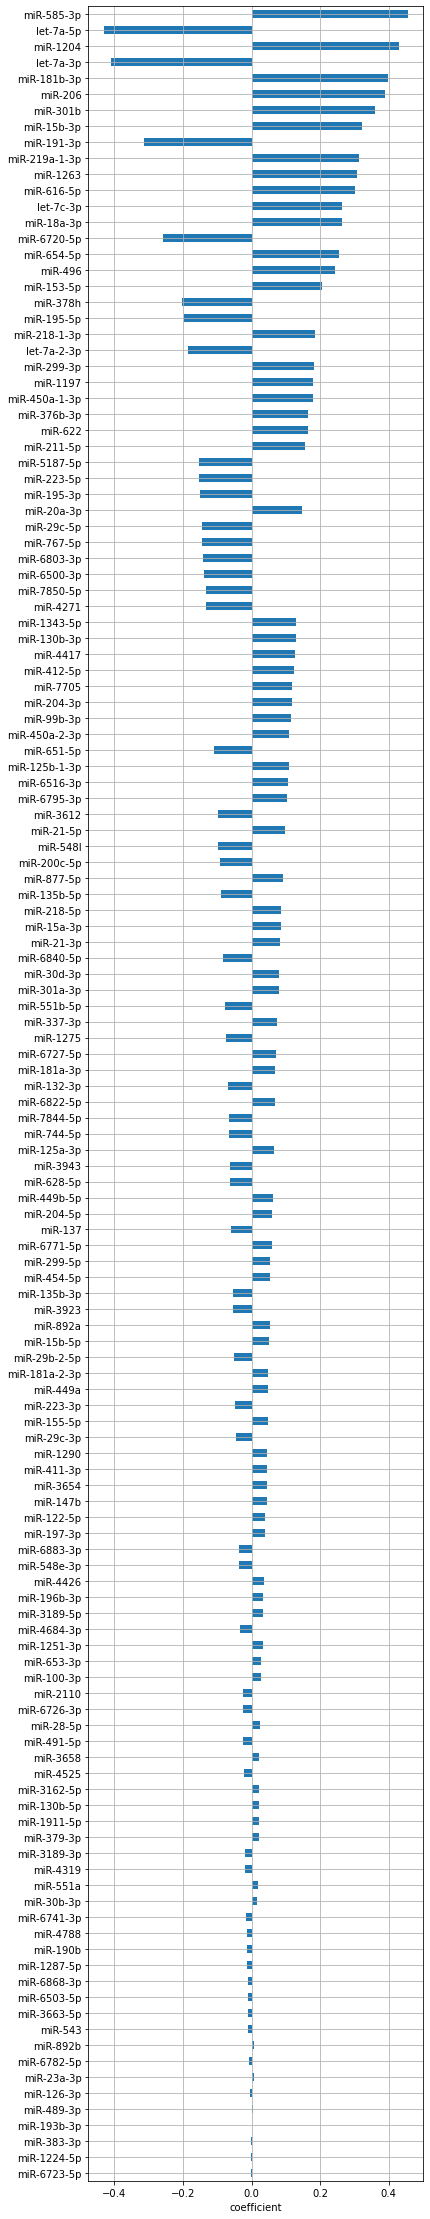

In [117]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xs.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 40))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [118]:
non_zero_coefs.abs().sort_values("coefficient", ascending=False)

,coefficient
miR-585-3p,0.456053
let-7a-5p,0.430889
miR-1204,0.430805
let-7a-3p,0.408175
miR-181b-3p,0.397613
...,...
miR-489-3p,0.002900
miR-193b-3p,0.002639
miR-383-3p,0.001673
miR-1224-5p,0.001390


---

In [119]:
coxnet = CoxnetSurvivalAnalysis(alphas=[0.1], l1_ratio=0.4)
coxnet.fit(Xs, y)
print(coxnet.score(Xs,y))

CoxnetSurvivalAnalysis(alphas=[0.1], l1_ratio=0.4)

In [120]:
pd.DataFrame(coxnet.coef_, index=Xs.columns, columns=['coefficients'])

,coefficients
let-7a-2-3p,0.000000
let-7a-3p,0.000000
let-7a-5p,0.000000
let-7b-5p,0.000000
let-7c-3p,0.036332
...,...
miR-96-5p,0.000000
miR-98-3p,0.000000
miR-99a-5p,0.000000
miR-99b-3p,0.000000


In [121]:
print(coxnet.score(Xs,y))

0.8969573577649587


In [139]:
coxnet = CoxnetSurvivalAnalysis(alphas=[0.1], l1_ratio=0.4)
coxnet.fit(Xs['let-7a-5p'], y)
print(coxnet.score(Xs['let-7a-5p'],y))

ValueError: Expected 2D array, got 1D array instead:
array=[-0.23168529  0.60001364  0.20209325 -1.21509538 -0.34934141 -0.26117771
  0.40211179  0.07172137 -1.154182    0.03098701 -0.72424485  0.66431371
 -0.11766673  0.23625805 -0.48419752  0.23781029 -1.07475158 -0.78529934
 -0.63575189 -0.96716146 -0.58565711 -0.78718084 -0.88147507  0.25226644
 -1.05360045 -1.01794613  0.22592551  0.10858298  1.19613379  1.32020267
  3.93780042  3.20246537  3.78616765  1.82061747 -0.47325349  2.54709382
  0.59269149  0.6239243   0.26480973  0.23157     1.51843379 -0.13336153
 -0.26478391  2.33763646 -0.22124299 -0.05672199  0.49425798  0.63690661
 -0.90030569 -0.57756668  0.11062126  0.2503379   0.31587663  0.58293908
 -0.5137997  -0.08828406  1.88824151  1.74333509  2.65385295 -0.83787143
  1.44011658  1.24462931 -0.01018636  0.13650749  0.25151384 -1.06720992
 -0.19772431 -0.13613673 -0.18499287  0.44113712 -0.0414662   4.1559597
  0.02393141  0.0446592   0.6089821  -0.19341256 -0.18262532  0.05340815
 -0.69922097  1.45672077  0.21330382 -0.45879734  1.53390908  0.54916625
  0.42133439 -0.55323268  0.73949509 -0.98362453  0.34138655  0.52926945
  0.00596314 -0.41574248 -1.51607178  0.78756728  0.73734706 -1.13447335
 -1.18038181  0.09886192 -0.77438667 -0.47939971 -1.06785277 -0.69948752
 -0.88102037 -1.0199217  -0.07770065 -0.18604337 -0.80333033 -1.18952274
 -0.691695   -0.36694906 -0.60375081 -0.60124215 -0.6084859  -0.79263717
 -1.56665262 -0.75858212 -0.38864896 -0.58703687 -0.48319405 -0.79147692
 -0.36387595 -0.62440021 -0.71679727 -0.72609498 -0.64989446 -0.59503322
 -0.62821024 -0.70158852 -0.01617578 -0.48921484 -0.78912505 -0.65873748
  0.33723159 -0.60890924 -0.72123446 -0.80367527 -0.86778719 -0.91153194
 -0.63035828 -0.18591794 -0.57127935 -0.89782839 -0.11363719 -0.18618448
 -0.64591196  0.35717543 -0.11867019 -0.25537644 -0.99292225 -1.11208357
 -0.41506828 -0.01396503 -0.29835291  0.08156785 -0.79630608 -0.03299948
 -0.97871697  0.06212574 -0.49677217  0.50750683 -0.39946755 -0.77145468
 -0.67364833  0.73842891  0.6817489  -0.44385514 -0.81275348 -0.77226999
 -0.54235138 -0.42104202 -0.92978244 -0.54597325 -0.88755856 -0.89876914
 -0.685831   -0.06526711 -0.34393211 -0.69679071  0.37498691  0.68693868
 -0.6503178  -0.94066374 -0.64826383 -0.44874703 -0.8966211  -0.24559267
 -0.80075896 -0.54972056  2.22824323 -0.11802735 -0.55142959 -0.71707949
  0.19103947  0.02742785 -0.54161446  2.3620802   0.32666386  1.12331996
  0.88347646  1.36692645  2.0157598   1.08713255  0.27868575  1.85912539
  2.35618486  1.69350684  1.89401143  0.92781701  2.0228154   1.35397549
  0.83298969  1.58431745  0.62740506 -0.16711867  1.43535013  0.34304854
  1.71385834  0.87894519  0.75359062  0.09412683 -0.95101196 -0.47094866
 -0.56108792 -0.84016058 -1.30633219 -0.73324466 -0.95519829 -0.74666599
 -0.88944006 -1.26196028  0.47299709 -0.32729656  1.42721266 -0.85489896
 -1.44540598].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [141]:
Xs['let-7a-5p']
print(y)

[(False, 3.3610e+03) (False, 1.8330e+03) (False, 3.3730e+03)
 (False, 1.8350e+03) (False, 2.3230e+03) (False, 1.6380e+03)
 (False, 2.0890e+03) ( True, 8.4300e+02) (False, 1.8290e+03)
 (False, 1.4770e+03) (False, 8.1500e+02) (False, 1.1200e+02)
 (False, 1.8410e+03) (False, 1.3930e+03) (False, 2.9110e+03)
 (False, 3.9820e+03) (False, 6.9760e+03) ( True, 1.7610e+03)
 (False, 3.1800e+02) (False, 1.8820e+03) (False, 2.1440e+03)
 ( True, 6.3800e+02) ( True, 1.5690e+03) ( True, 2.9400e+02)
 ( True, 6.1100e+02) ( True, 2.2500e+02) ( True, 2.7600e+02)
 ( True, 4.8200e+02) ( True, 2.7300e+02) (False, 1.7010e+03)
 (False, 1.6480e+03) (False, 3.0200e+02) ( True, 2.1400e+02)
 (False, 4.2850e+03) (False, 1.4510e+03) ( True, 2.0660e+03)
 (False, 1.7110e+03) (False, 2.9190e+03) (False, 2.9190e+03)
 (False, 3.3290e+03) (False, 5.7500e+02) (False, 1.5390e+03)
 ( True, 6.1500e+02) (False, 1.8750e+03) (False, 1.3500e+02)
 ( True, 3.7480e+03) (False, 2.9580e+03) (False, 4.8800e+02)
 ( True, 1.0000e+00) ( T

---

## Which variable is the most predictive of OS?

In [122]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(Xs.values, y)
pd.Series(scores, index=Xs.columns).sort_values(ascending=False)

/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:183: RuntimeWarning: divide by zero encountered in log
  loss -= (numerator - n_events * np.log(risk_set)) / n_samples
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:183: RuntimeWarning: invalid value encountered in double_scalars
  loss -= (numerator - n_events * np.log(risk_set)) / n_samples
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:198: RuntimeWarning: overflow encountered in exp
  exp_xw = np.exp(offset + np.dot(x, w))
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:242: RuntimeWarning: invalid value encountered in true_divide
  z = risk_set_x / risk_set
/Users/arifs2/opt/anaconda3/lib/python3.9/site-packages/sksurv/linear

ValueError: search direction contains NaN or infinite values

In [123]:
pd.DataFrame(scores, index=Xs.columns, columns=['c-index']).sort_values('c-index', ascending=False)

NameError: name 'scores' is not defined

---

## Overlap between RFE-selected miRNAs and prognostic miRNAs by CoxNet model

In [124]:
# 324 miRNAs from RFE-CV
rfecv_df = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_rfecv_selected_features_df.csv")
rfecv_list = rfecv_df.iloc[:,2:].columns

# 39 miRNAs from RFE-CV + DE miRNAs overlap
rfecv_overlap_df = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_rfecv_overlap_features_df.csv")
rfecv_overlap_list = rfecv_overlap_df.iloc[:,2:].columns

# 100 miRNAs requested from from RFE
rfe100_df = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/OpenPBTA miRNA Projects/datasets/pbta_rfe_100_selected_features_df.csv")
rfe100_list = rfe100_df.iloc[:,2:].columns

rfecv_list

Index(['miR-92b-3p', 'miR-22-3p', 'miR-223-5p', 'miR-223-3p', 'miR-222-5p',
       'miR-222-3p', 'miR-221-5p', 'miR-221-3p', 'miR-219a-2-3p',
       'miR-500a-3p',
       ...
       'miR-590-5p', 'miR-6511a-3p', 'miR-876-3p', 'miR-128-3p', 'miR-935',
       'miR-584-5p', 'miR-1296-5p', 'miR-551a', 'miR-615-3p', 'miR-146b-5p'],
      dtype='object', length=324)

In [125]:
# Find overlap between the two miRNA lists

# Function to intersect two lists
def intersect(lst1, lst2):
    return list(set(lst1) & set(lst2))

#intersect(rfecv_overlap_list, rfe100_list)

In [128]:
print(intersect(non_zero_coefs.index, rfecv_list))
print(len(intersect(non_zero_coefs.index, rfecv_list)))

['miR-454-5p', 'miR-6726-3p', 'miR-301a-3p', 'miR-132-3p', 'miR-130b-5p', 'miR-211-5p', 'miR-1197', 'miR-29b-2-5p', 'miR-196b-3p', 'miR-125b-1-3p', 'miR-6503-5p', 'miR-125a-3p', 'miR-6771-5p', 'miR-3654', 'miR-15b-5p', 'miR-3162-5p', 'miR-223-3p', 'miR-1251-3p', 'miR-195-3p', 'miR-6516-3p', 'miR-877-5p', 'miR-551a', 'miR-30d-3p', 'miR-18a-3p', 'miR-3663-5p', 'miR-135b-5p', 'miR-20a-3p', 'miR-491-5p', 'miR-744-5p', 'miR-190b', 'miR-223-5p', 'miR-654-5p', 'miR-489-3p', 'miR-130b-3p', 'miR-299-3p', 'miR-15b-3p', 'miR-6727-5p', 'miR-23a-3p', 'miR-181a-2-3p', 'miR-29c-5p', 'miR-137', 'miR-195-5p', 'miR-378h', 'miR-301b', 'miR-337-3p']
45


In [130]:
print(intersect(non_zero_coefs.index, rfecv_overlap_list))
print(len(intersect(non_zero_coefs.index, rfecv_overlap_list)))

['miR-15b-3p', 'miR-135b-5p', 'miR-137']
3


In [131]:
print(intersect(non_zero_coefs.index, rfe100_list))
print(len(intersect(non_zero_coefs.index, rfe100_list)))

['miR-15b-3p', 'miR-6727-5p', 'miR-219a-1-3p', 'miR-132-3p', 'miR-130b-5p', 'miR-491-5p', 'miR-1251-3p', 'miR-195-3p', 'miR-6516-3p', 'miR-301b']
10


In [143]:
clusters = pd.read_csv("/Users/arifs2/OneDrive - Children's Hospital of Philadelphia/PBTA_shinyapp_miRNA/pbta_shiny_gng_clustering/gng_pam_pearson_10_cluster_members.csv")
clusters

,Sample_ID,cluster,short_histology,composition_type,molecular_subtype
0,7316-101,2,"GNG, wildtype",RNA,"GNG, wildtype"
1,7316-120,1,"GNG, KIAA1549-BRAF",RNA,"GNG, KIAA1549-BRAF"
2,7316-156,1,"GNG, RTK",RNA,"GNG, RTK"
3,7316-157,1,"GNG, To be classified",RNA,"GNG, To be classified"
4,7316-1793,1,"GNG, BRAF V600E",RNA,"GNG, BRAF V600E"
5,7316-1854,2,"GNG, RTK",RNA,"GNG, RTK"
6,7316-230,1,"GNG, other MAPK, IDH",RNA,"GNG, other MAPK, IDH"
7,7316-2760,2,"GNG, wildtype",RNA,"GNG, wildtype"
8,7316-2901,1,"GNG, RTK",RNA,"GNG, RTK"
9,7316-3060,2,"GNG, BRAF V600E, CDKN2A/B",RNA,"GNG, BRAF V600E, CDKN2A/B"


In [156]:
cdf = pd.merge(clusters, clinical, on='Sample_ID', how='inner')
cdf2 = pd.merge(clusters, mirna, on='Sample_ID', how='inner')
cdf2

,Sample_ID,cluster,short_histology,composition_type,molecular_subtype,class,let-7a-2-3p,let-7a-3p,let-7a-5p,let-7b-5p,...,miR-944,miR-95-3p,miR-95-5p,miR-9-5p,miR-96-3p,miR-96-5p,miR-98-3p,miR-99a-5p,miR-99b-3p,miR-99b-5p
0,7316-101,2,"GNG, wildtype",RNA,"GNG, wildtype",Ganglioglioma,90,4,87665,92903,...,2,376,1,8763,1,9,0,91472,552,16924
1,7316-120,1,"GNG, KIAA1549-BRAF",RNA,"GNG, KIAA1549-BRAF",Ganglioglioma,59,44,87390,42054,...,1,1108,0,166140,3,1056,8,39954,316,8829
2,7316-156,1,"GNG, RTK",RNA,"GNG, RTK",Ganglioglioma,99,82,101527,54115,...,8,464,10,116098,23,321,11,47439,859,23214
3,7316-1793,1,"GNG, BRAF V600E",RNA,"GNG, BRAF V600E",Ganglioglioma,183,22,99351,33067,...,0,829,2,39486,1,12,0,47516,247,6096
4,7316-1854,2,"GNG, RTK",RNA,"GNG, RTK",Ganglioglioma,122,24,102849,158323,...,1,248,0,13246,2,10,5,109469,764,21661
5,7316-230,1,"GNG, other MAPK, IDH",RNA,"GNG, other MAPK, IDH",Ganglioglioma,152,419,365064,199949,...,9,3328,8,650772,1,3137,27,153541,1001,32263
6,7316-2760,2,"GNG, wildtype",RNA,"GNG, wildtype",Ganglioglioma,37,8,88353,137529,...,7,523,5,6213,3,17,8,75438,881,20527
7,7316-2901,1,"GNG, RTK",RNA,"GNG, RTK",Ganglioglioma,122,44,138841,55817,...,7,1515,2,153287,5,29,4,71932,326,10976
8,7316-3060,2,"GNG, BRAF V600E, CDKN2A/B",RNA,"GNG, BRAF V600E, CDKN2A/B",Ganglioglioma,97,26,116042,171366,...,5,113,3,13928,1,14,1,118416,731,20261
9,7316-319,2,"GNG, IDH",RNA,"GNG, IDH",Ganglioglioma,61,11,31935,68334,...,5,151,7,4285,13,146,8,36050,275,7227


In [155]:
cdf2.to_csv('pbta_gng_cluster_clinical_data.csv')